# Lesson: Advanced Image Understanding

Welcome to this lesson on image understanding with the Gemini API. We'll cover several exciting capabilities:

1.  **Describing an Image:** The basic ability to understand and describe the content of a picture.
2.  **Interactive Games:** A fun "Guess the Shape" game to demonstrate rule-following and visual reasoning.
3.  **Object Detection:** Advanced techniques to detect objects within an image.

In [1]:
#@title 1. Setup
# Install the Google AI Python SDK
!pip install -q -U google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.9/245.9 kB 8.0 MB/s eta 0:00:00


In [2]:
#@title 2. Configure your API Key
# Use the "Secrets" tab in Colab (click the key icon on the left) to store your
# API key with the name "GOOGLE_API_KEY".

from google import genai
from google.colab import userdata

try:
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    client = genai.Client(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
    print('Secret not found. Please add your GOOGLE_API_KEY to the Colab Secrets Manager.')

## Part 1: Describing an Image

Let's start with the most fundamental multimodal task: asking the model to describe what it sees in an image.

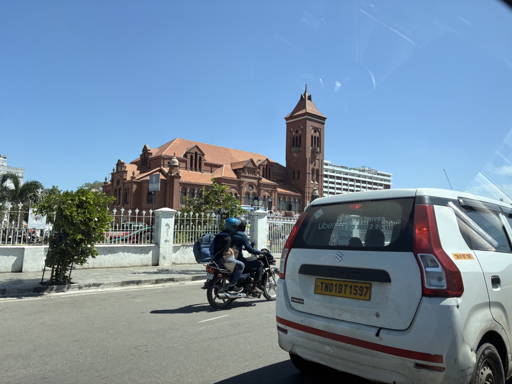

## Red Bricks, Blue Sky, Busy Lives

Ever caught a glimpse that tells a whole story? This snapshot from a bustling Indian street does exactly that.

Dominating the frame, even from behind a car windshield, is this magnificent edifice of red brick. Its grand architecture, complete with a stately tower, whispers tales of a bygone era. You can almost feel the history embedded in its intricate design, standing proud under a brilliant, cloudless sky.

But look closer, and the vibrant present comes roaring into view. An Uber driver awaits their next passenger, reflecting the pulse of modern urban life. A delivery rider, likely on a mission to bring dinner or essentials, zips by – a symbol of today's fast-paced world.

It's a beautiful juxtaposition: the enduring legacy of the past harmoniously woven into the fabric of daily hustle and bustle. The majestic structure isn't just a relic; it's a silent witness to the city's continuous evolution, a landmark grounding the vibrant chaos around it.

This image isn't just a picture; it's a reminder that every city holds countless stories, where history isn't just in museums, but alive on its streets, breathing alongside us every single day.

In [9]:
#@title Load image and generate description
import requests
from google.genai import types
from IPython.display import display, Markdown, Image

image_path = "https://raw.githubusercontent.com/gopidon/gemini-advanced-api-course/main/Section_2_Advanced_Multimodality/images/describe.png"
display(Image(image_path))

image_bytes = requests.get(image_path).content
image = types.Part.from_bytes(
  data=image_bytes, mime_type="image/png"
)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=["Write a short and engaging blog post based on this picture.", image],
)
display(Markdown(response.text))

## Part 2: Interactive Game - Guess the Shape

Now for a more interactive example. We'll have the AI play a "Guess the Shape" game, where it has to guess a shape we've drawn by asking a limited number of questions. This demonstrates visual reasoning and the ability to follow rules.

In [ ]:
def get_image_from_url(url):
  image_bytes = requests.get(url).content
  image = types.Part.from_bytes(
    data=image_bytes, mime_type="image/png"
  )
  return image

triangle = get_image_from_url("https://raw.githubusercontent.com/gopidon/gemini-advanced-api-course/main/Section_2_Advanced_Multimodality/images/triangle.png")
square = get_image_from_url("https://raw.githubusercontent.com/gopidon/gemini-advanced-api-course/main/Section_2_Advanced_Multimodality/images/square.png")
pentagon = get_image_from_url("https://raw.githubusercontent.com/gopidon/gemini-advanced-api-course/main/Section_2_Advanced_Multimodality/images/pentagon.png")


prompt = """
    Look at this sequence of three shapes. What shape should come as the fourth shape? Explain
    your reasoning with detailed descriptions of the first shapes.
"""

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=[
        prompt,
        triangle,
        square,
        pentagon
    ]
)

display(Markdown(response.text))

Let's break down the sequence of shapes:

1.  **First Shape:** This is a **triangle**. It is a polygon characterized by having **three** straight sides and three vertices (corners).

2.  **Second Shape:** This is a **square** (or more broadly, a quadrilateral). It is a polygon characterized by having **four** straight sides and four vertices. All angles appear to be 90 degrees, and all sides appear roughly equal in length, making it a square.

3.  **Third Shape:** This is a **pentagon**. It is a polygon characterized by having **five** straight sides and five vertices.

**Reasoning for the Fourth Shape:**

Observing the sequence, there is a clear and consistent pattern:
*   The first shape has 3 sides.
*   The second shape has 4 sides.
*   The third shape has 5 sides.

Each successive shape in the sequence increases the number of sides by one.

Following this pattern, the fourth shape in the sequence should have **six** sides.

Therefore, the fourth shape should be a **hexagon**.

## Part3: Object Detection

This code snippet demonstrates how to use the Gemini API for object detection and labeling. It defines a prompt to detect cupcakes in an image and label them based on their toppings. It then loads an image from a URL, configures the API to return the response in JSON format, and sends the image and prompt to the `gemini-2.5-flash` model to generate the bounding boxes and labels.

In [14]:
import json
from PIL import Image
from io import BytesIO

prompt = """
          Detect the 2d bounding boxes of the multiple cupcakes present in the image. The label for each cupcake must be its topping description.
          Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
          If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
         """


image_path = "https://raw.githubusercontent.com/gopidon/gemini-advanced-api-course/main/Section_2_Advanced_Multimodality/images/cupcakes.png"


image = Image.open(BytesIO(requests.get(image_path).content))
# display(image)
# print(image.size)

config = types.GenerateContentConfig(
  response_mime_type="application/json",
  temperature=0.5
)

response = client.models.generate_content(model="gemini-2.5-flash",
                                          contents=[image, prompt],
                                          config=config
                                          )

The following code defines a function `plot_bounding_boxes` that takes an image and a list of bounding boxes (in JSON format) as input. It iterates through the bounding boxes, converts the normalized coordinates to absolute pixel coordinates, and draws rectangles on the image using different colors for each box. It also includes a check to ensure the coordinates are in the correct order (top-left, bottom-right).

In [25]:
import random
import io
from PIL import Image, ImageDraw, ImageFont, ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    #bounding_boxes = parse_json(bounding_boxes)

    #font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color)

    # Display the image
    img.show()

(620, 620)


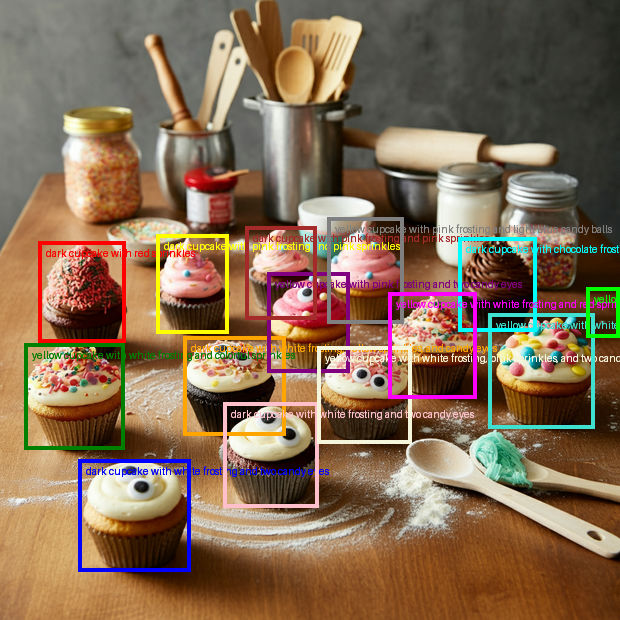

In [27]:
plot_bounding_boxes(image, response.text)
image